In [1]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep=';', index_col = 0)

In [3]:
df.head()

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [4]:
df.version.unique()

array(['v2.8.0', 'v2.9.0', 'v3.7.4.0', 'v3.8.0.0'], dtype=object)

In [5]:
df.experimentVariant.unique()

array([1, 0])

In [6]:
df.purchase.unique()

array([0, 1])

In [7]:
df.isna().sum()

uid                  0
experimentVariant    0
version              0
purchase             0
dtype: int64

In [9]:
# группируем данные по версиям мобильного приложения и экспериментам и считаем среднее для покупки и количество сгруппированных юзеров.  
df.groupby(['version', 'experimentVariant'], as_index = False) \
    .agg({'purchase':'mean', 'uid' : 'count'})

#мы видим существенную разницу в средних между двумя экспериментами в версии "v2.8.0". 

,version,experimentVariant,purchase,uid
0,v2.8.0,0,0.000993,41283
1,v2.8.0,1,0.045606,41552
2,v2.9.0,0,0.074658,11921
3,v2.9.0,1,0.071304,12033
4,v3.7.4.0,0,0.059943,4204
5,v3.7.4.0,1,0.063018,4221
6,v3.8.0.0,0,0.057604,5694
7,v3.8.0.0,1,0.062848,6110


  0%|          | 0/1000 [00:00<?, ?it/s]

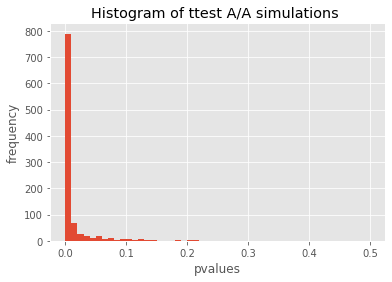

0.913

In [28]:
# Проведем симуляицю А/А теста в двух экспериментальных группах. 
# Запуск симуляций A/A теста
n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = df[df['experimentVariant'] == 0]['purchase'].sample(n_s, replace = False).values
    s2 = df[df['experimentVariant'] == 1]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

# Вывод: почти в 91% случаев мы бы получали статистически значимые результаты между группами,  
# которые должны были бы быть по идее одинаковыми. Чем же это обусловено? 

In [9]:
df[(df['experimentVariant'] == 0) & (df['version'] == 'v2.8.0')]['purchase']
df[(df['experimentVariant'] == 1) & (df['version'] == 'v2.8.0')]['purchase']

1         0
3         0
4         0
5         0
6         0
         ..
127010    0
127011    0
127016    0
127017    0
127018    0
Name: purchase, Length: 63916, dtype: int64

  0%|          | 0/1000 [00:00<?, ?it/s]

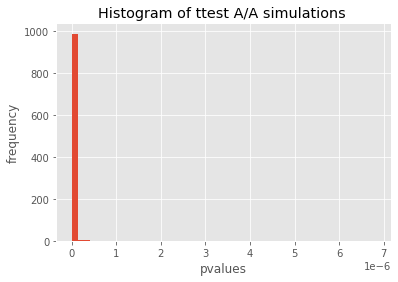

1.0

In [26]:
# Проведем А/А тест в двух экспериментальных группах и добавим к нему версию мобильного приложения "v.2.8.0"
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df['experimentVariant'] == 0) & (df['version'] == 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df['experimentVariant'] == 1) & (df['version'] == 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

# Вероятность получить статистически значимый результат в двух выборках при условии, что выборки по идеи должны быть одинаковыми, равен почти 100%
# Именно в этой версии МП присутствует аномалия. 

  0%|          | 0/1000 [00:00<?, ?it/s]

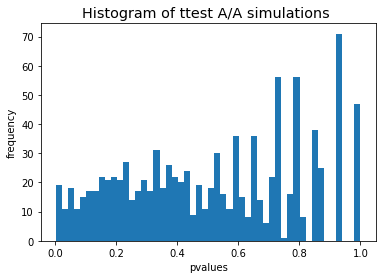

0.039

In [10]:
#Проведем теперь А/А тестирование и возьмем все версию мб, кроме 'v2.8.0'. 
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df['experimentVariant'] == 0) & (df['version'] != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df['experimentVariant'] == 1) & (df['version'] != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

#Вероятность получить положительный результат равен в выборках, которые не отличаются между собой, равен почти 4%. 
#А это говорит нам о том, что именно из-за версия мобильного приложения "v.2.8.0" возникают статистически значимые различия. 

  0%|          | 0/1000 [00:00<?, ?it/s]

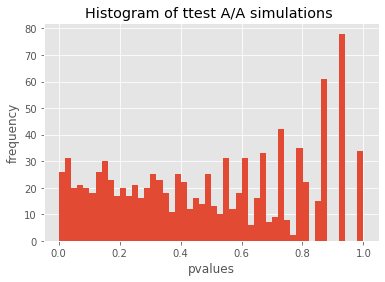

0.066

In [22]:
# Проведем А/А тест в двух экспериментальных группах и добавим к нему версию мобильного приложения "v.2.9.0"
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df['experimentVariant'] == 0) & (df['version'] == 'v2.9.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df['experimentVariant'] == 1) & (df['version'] == 'v2.9.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

# Вероятность получить статистически значимые различия между двумя выборками равно почти 7%. 
# Однако эта версия мобильного приложения оказывает не существена для нашего выборки в целом, поскольку при проведении 
# А/А теста, где были взяты все версии мобильные приложения, кроме 'v2.8.0', FPR был меньше 0.05.

  0%|          | 0/1000 [00:00<?, ?it/s]

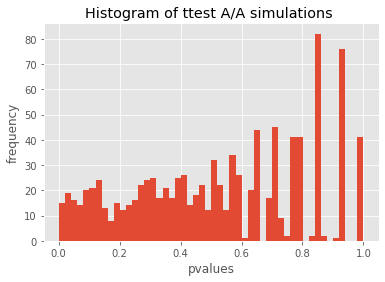

0.043

In [23]:
#Аналогично и для этой версии. 
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df['experimentVariant'] == 0) & (df['version'] == 'v3.7.4.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df['experimentVariant'] == 1) & (df['version'] == 'v3.7.4.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

  0%|          | 0/1000 [00:00<?, ?it/s]

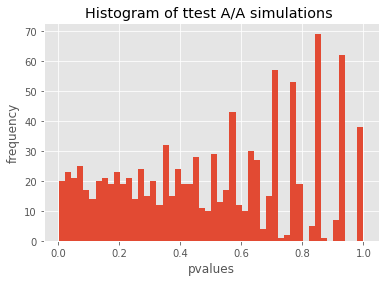

0.051

In [25]:
# Как и для этой. :)
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df['experimentVariant'] == 0) & (df['version'] == 'v3.8.0.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df['experimentVariant'] == 1) & (df['version'] == 'v3.8.0.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

In [ ]:
# Вывод: если мы уберем версию "v2.8.0" мобильного приложения прежде, чем заходим провести, скажем, A/B тестирование,  
# вероятность получить стастически значимые различия в двух экспериментальных группах будет < 0.05. Именно из-за этой версии и возникают все проблемы. 